# Step1. 검증용 데이터셋 준비
OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.

가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천합니다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.

In [1]:
import os
import keras_ocr
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt


from glob import glob
# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [2]:
path = './images_file'
img_path = glob(path+'/*')

print(img_path)

['./images_file/다운로드 (9).jfif', './images_file/다운로드 (8).jfif', './images_file/다운로드 (6).jfif', './images_file/다운로드 (7).jfif', './images_file/다운로드.jfif', './images_file/다운로드 (5).jfif', './images_file/다운로드 (4).jfif', './images_file/다운로드 (2).jfif', './images_file/다운로드 (1).jfif', './images_file/다운로드 (3).jfif']


# Step2. keras-ocr, Tesseract로 테스트 진행

## keras-ocr

In [3]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 


images = [ keras_ocr.tools.read(url) for url in img_path]
prediction_groups = [pipeline.recognize([url]) for url in img_path]

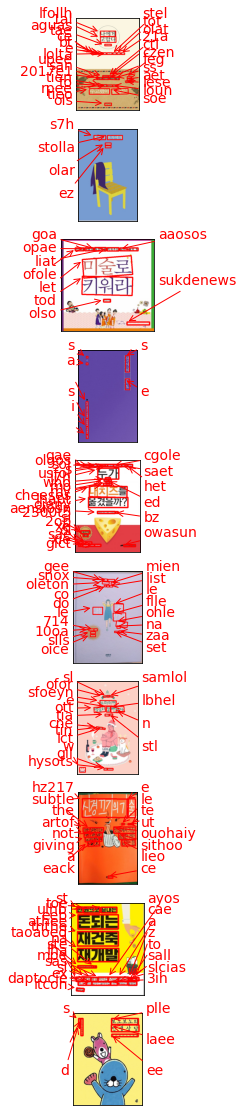

In [4]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

(주의사항) keras-ocr은 한글 데이터셋으로 훈련이 되어있지 않은 모델입니다. 한글 텍스트의 detection은 정상적으로 진행되더라도 recognition 결과가 엉뚱하게 나올 수 있음에 주의해 주세요.

## Tesseract

In [5]:
def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [10]:
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/images_file'
img_file_path = work_dir + '/다운로드 (1).jfif'   #테스트용 이미지 경로입니다. 한개선택

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/images_file/0000.png
/aiffel/aiffel/ocr_python/images_file/0001.png
/aiffel/aiffel/ocr_python/images_file/0002.png
/aiffel/aiffel/ocr_python/images_file/0003.png
/aiffel/aiffel/ocr_python/images_file/0004.png
/aiffel/aiffel/ocr_python/images_file/0005.png
/aiffel/aiffel/ocr_python/images_file/0006.png
/aiffel/aiffel/ocr_python/images_file/0007.png
/aiffel/aiffel/ocr_python/images_file/0008.png
/aiffel/aiffel/ocr_python/images_file/0009.png
/aiffel/aiffel/ocr_python/images_file/0010.png
/aiffel/aiffel/ocr_python/images_file/0011.png
/aiffel/aiffel/ocr_python/images_file/0012.png
/aiffel/aiffel/ocr_python/images_file/0013.png
/aiffel/aiffel/ocr_python/images_file/0014.png
/aiffel/aiffel/ocr_python/images_file/0015.png
/aiffel/aiffel/ocr_python/images_file/0016.png
/aiffel/aiffel/ocr_python/images_file/0017.png
/aiffel/aiffel/ocr_python/images_file/0018.png
/aiffel/aiffel/ocr_python/images_file/0019.png
/aiffel/aiffel/ocr_python/images_file/0020.png
/aiffel/aiffe

In [11]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 영어라면 lang='eng'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

하

견으로

슨내는

“…”

= 미른


재개발

이

월 정이넘쳐(이정월) 5

제

노"

어

0}

고.

배위

00

뻐벅는

사업

도 이

2370 /

쇠고의

두사

삭사가

알려주는

3개의

시나

나승식 왁용법!

보그

Done


하

Done


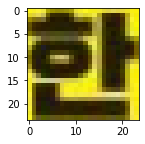

견으로

Done


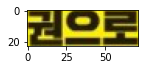

슨내는

Done


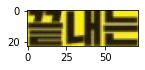

“…”

Done


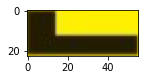

= 미른

Done


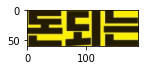


Done


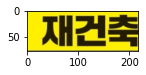

재개발

Done


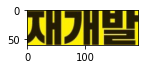

이

Done


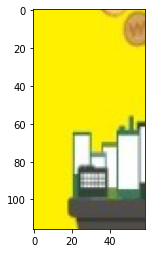

월 정이넘쳐(이정월) 5

Done


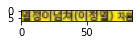

제

Done


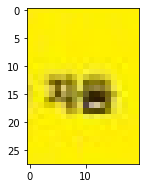

노"

Done


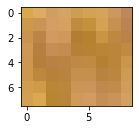

어

Done


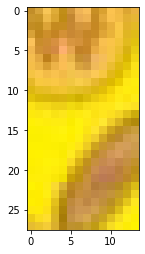

0}

Done


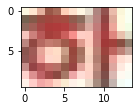

고.

Done


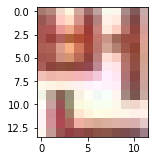

배위

Done


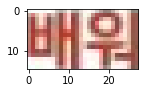

00

Done


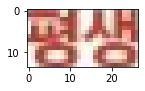

뻐벅는

Done


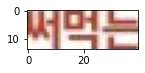

사업

Done


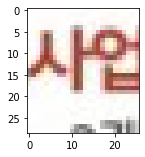

도 이

Done


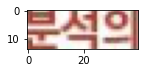

2370 /

Done


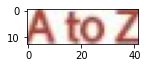

쇠고의

Done


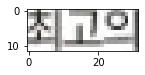

두사

Done


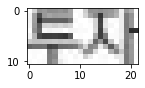

삭사가

Done


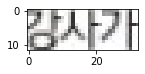

알려주는

Done


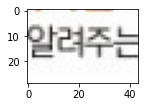

3개의

Done


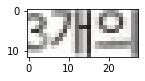

시나

Done


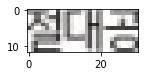

나승식 왁용법!

Done


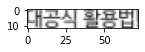

보그

Done


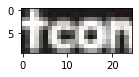

In [12]:
# 이미지로 시각화하여 결과학인
for i in range(len(cropped_image_path_list)):
    plt.figure(figsize = (2, 10))
    pil_img = Image.open(cropped_image_path_list[i])
    recognize_images([cropped_image_path_list[i]])
    plt.imshow(pil_img)
    plt.show()

# Step3. 결과 분석과 결론 제시
우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다. 여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시합니다. 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

* keras-ocr 한글 데이터셋으로 훈련되어있지 않아 예상대로 정말 엉뚱한 결과가 나왔다. 

* 테서렉트에서 조금 기대를 했지만 한글이 올바르게 해석된 부분이 거이 없었다. 특히나 작은 글씨 일수록 더욱 인식을 하지 못했다.